In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# We'll implement technical indicators manually using pandas and numpy
from scipy import stats

print("Environment setup complete!")
print("Ready untuk Mean Reversal Trading Analysis (SPOT MARKET)")
print("-" * 50)

Environment setup complete!
Ready untuk Mean Reversal Trading Analysis (SPOT MARKET)
--------------------------------------------------


In [105]:
print("SIMPLE DEMO: BTC Mean Reversal Strategy")
print("Period: 1 Jan 2025 - 30 Jun 2025")
print("Initial Capital: $1,000")
print("-" * 50)

# Fetch 2025 data for BTC
def get_2025_data():
    try:
        # Menambahkan progress=False agar output lebih bersih
        data = yf.download("BTC-USD", start="2025-01-01", end="2025-06-30", progress=False) 

        # Menangani MultiIndex jika yfinance mengembalikannya
        if hasattr(data.columns, 'levels'):
            data.columns = data.columns.droplevel(1) 

        # Membersihkan nama kolom
        new_columns = []
        for col in data.columns:
            if isinstance(col, str):
                new_col = col.lower().replace(' ', '_')
            else:
                new_col = str(col).lower().replace(' ', '_')
            new_columns.append(new_col)
        data.columns = new_columns
        
        print(f"BTC 2025 data loaded: {len(data)} days")
        print(f"Start price: ${data['close'].iloc[0]:,.2f}")
        print(f"End price: ${data['close'].iloc[-1]:,.2f}")
        return data

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Get BTC 2025 data
btc_2025 = get_2025_data()

SIMPLE DEMO: BTC Mean Reversal Strategy
Period: 1 Jan 2025 - 30 Jun 2025
Initial Capital: $1,000
--------------------------------------------------
BTC 2025 data loaded: 180 days
Start price: $94,419.76
End price: $108,385.57


In [106]:
# Calculate BB and RSI indicators (same as before)
def add_indicators(df):
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    rolling_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (rolling_std * 2)
    df['bb_lower'] = df['bb_middle'] - (rolling_std * 2)

    # RSI
    price_change = df['close'].diff()
    gains = price_change.where(price_change > 0, 0)
    losses = -price_change.where(price_change < 0, 0)
    avg_gains = gains.rolling(window=14).mean()
    avg_losses = losses.rolling(window=14).mean()
    # Hindari pembagian dengan nol jika avg_losses adalah 0
    rs = avg_gains / avg_losses.replace(0, np.nan) 
    df['rsi'] = 100 - (100 / (1 + rs))
    # Isi nilai NaN di awal RSI dengan 50 (netral)
    df['rsi'] = df['rsi'].fillna(50) 
    
    return df

In [107]:
# Add indicators to data
btc_2025 = add_indicators(btc_2025)
print("\nFirst few rows with indicators:")
# Display 25 rows to see when indicators start calculating
print(btc_2025[['close', 'bb_upper', 'bb_middle', 'bb_lower', 'rsi']].head(25)) 

print("\nIndicators calculated")
print(f"RSI range: {btc_2025['rsi'].min():.1f} - {btc_2025['rsi'].max():.1f}")
print("-" * 50)


First few rows with indicators:
                    close       bb_upper     bb_middle      bb_lower  \
Date                                                                   
2025-01-01   94419.757812            NaN           NaN           NaN   
2025-01-02   96886.875000            NaN           NaN           NaN   
2025-01-03   98107.429688            NaN           NaN           NaN   
2025-01-04   98236.226562            NaN           NaN           NaN   
2025-01-05   98314.960938            NaN           NaN           NaN   
2025-01-06  102078.085938            NaN           NaN           NaN   
2025-01-07   96922.703125            NaN           NaN           NaN   
2025-01-08   95043.523438            NaN           NaN           NaN   
2025-01-09   92484.039062            NaN           NaN           NaN   
2025-01-10   94701.453125            NaN           NaN           NaN   
2025-01-11   94566.593750            NaN           NaN           NaN   
2025-01-12   94488.437500      

In [108]:
# Trading variables
initial_capital = 1000
current_cash = 1000
crypto_holdings = 0
avg_buy_price = 0
total_invested = 0
trades = []

In [109]:

# Trading function
def execute_trade(action, date, price, rsi_value):
    global current_cash, crypto_holdings, avg_buy_price, total_invested

    if action == "BUY" and current_cash > 50: # Minimum $50 for trade
        # Use 50% of available cash
        investment = current_cash * 0.5
        fee = investment * 0.001 # 0.1% fee
        net_investment = investment - fee
        crypto_bought = net_investment / price

        # Update average price for DCA (Dollar Cost Averaging)
        if crypto_holdings > 0:
            total_value = (crypto_holdings * avg_buy_price) + net_investment
            total_crypto = crypto_holdings + crypto_bought
            avg_buy_price = total_value / total_crypto
        else:
            avg_buy_price = price # First buy

        crypto_holdings += crypto_bought
        total_invested += net_investment # Track total cost basis
        current_cash -= investment

        trade_info = {
            'date': date,
            'action': 'BUY',
            'price': price,
            'amount': investment, # Gross amount before fee
            'crypto_bought': crypto_bought,
            'rsi': rsi_value,
            'cash_after': current_cash
        }
        trades.append(trade_info)
        return trade_info

    elif action == "SELL" and crypto_holdings > 0:
        # Sell all holdings
        sell_value = crypto_holdings * price
        fee = sell_value * 0.001 # 0.1% fee
        net_proceeds = sell_value - fee
        profit = net_proceeds - total_invested

        trade_info = {
            'date': date,
            'action': 'SELL',
            'price': price,
            'crypto_sold': crypto_holdings,
            'sell_value': sell_value, # Gross value before fee
            'net_proceeds': net_proceeds,
            'profit': profit,
            'rsi': rsi_value,
            'avg_buy_price': avg_buy_price # Record avg price before reset
        }
        trades.append(trade_info)

        # Reset position
        current_cash += net_proceeds
        crypto_holdings = 0
        avg_buy_price = 0
        total_invested = 0
        return trade_info

    return None # No action taken

In [110]:
# Run simple backtest
print("Running backtest...\n")

# Skip first 20 rows due to BB calculation needing 20 periods
test_data = btc_2025.iloc[30:].copy() 

for date, row in test_data.iterrows():
    price = row['close']
    rsi = row['rsi']
    bb_upper = row['bb_upper']
    bb_lower = row['bb_lower']

    # Simple trading signals
    # Buy when RSI is oversold (<30) AND price touches or goes below the lower Bollinger Band
    buy_signal = (rsi < 30 and price < bb_lower) 
    # Sell when RSI is overbought (>70) AND price touches or goes above the upper Bollinger Band
    # Also check if we actually hold any crypto to sell
    sell_signal = (rsi > 70 and price > bb_upper and crypto_holdings > 0) 

    if buy_signal:
        trade = execute_trade("BUY", date, price, rsi)
        if trade:
            print(f"🛒 BUY: {date.strftime('%Y-%m-%d')}")
            print(f"   Price: ${price:,.2f}, RSI: {rsi:.1f}")
            print(f"   Invested: ${trade['amount']:,.2f}")
            print(f"   BTC bought: {trade['crypto_bought']:.6f}")
            print(f"   Cash left: ${trade['cash_after']:,.2f}\n")
            
    elif sell_signal:
        trade = execute_trade("SELL", date, price, rsi)
        if trade:
            print(f"💰 SELL: {date.strftime('%Y-%m-%d')}")
            print(f"   Price: ${price:,.2f}, RSI: {rsi:.1f}")
            print(f"   BTC sold: {trade['crypto_sold']:.6f}")
            print(f"   Proceeds: ${trade['net_proceeds']:,.2f}")
            print(f"   Profit: ${trade['profit']:,.2f}")
            print(f"   Buy price was: ${trade['avg_buy_price']:,.2f}\n")

# Final results
final_price = test_data['close'].iloc[-1]
# Calculate current value of any remaining crypto holdings
final_portfolio_value = current_cash + (crypto_holdings * final_price) 
total_return = final_portfolio_value - initial_capital
return_pct = (total_return / initial_capital) * 100

print("=" * 50)
print("FINAL RESULTS")
print("=" * 50)
print("Period: Jan 1 - Jun 30, 2025") # Assuming the dates from get_2025_data
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Return: ${total_return:+,.2f}") # Perbaikan format
print(f"Return Percentage: {return_pct:+.2f}%")
print() # Baris kosong sesuai referensi

Running backtest...

🛒 BUY: 2025-02-26
   Price: $84,347.02, RSI: 19.2
   Invested: $500.00
   BTC bought: 0.005922
   Cash left: $500.00

🛒 BUY: 2025-02-27
   Price: $84,704.23, RSI: 21.7
   Invested: $250.00
   BTC bought: 0.002948
   Cash left: $250.00

🛒 BUY: 2025-02-28
   Price: $84,373.01, RSI: 17.9
   Invested: $125.00
   BTC bought: 0.001480
   Cash left: $125.00

🛒 BUY: 2025-04-08
   Price: $76,271.95, RSI: 24.8
   Invested: $62.50
   BTC bought: 0.000819
   Cash left: $62.50

💰 SELL: 2025-04-22
   Price: $93,441.89, RSI: 79.7
   BTC sold: 0.011169
   Proceeds: $1,042.62
   Profit: $106.06
   Buy price was: $83,852.92

🛒 BUY: 2025-06-05
   Price: $101,575.95, RSI: 22.2
   Invested: $552.56
   BTC bought: 0.005434
   Cash left: $552.56

FINAL RESULTS
Period: Jan 1 - Jun 30, 2025
Initial Capital: $1,000.00
Final Portfolio Value: $1,141.57
Total Return: $+141.57
Return Percentage: +14.16%



In [111]:
# Current position
if crypto_holdings > 0:
    print("\nCurrent Position: HOLDING BTC")
    print(f"  BTC Amount: {crypto_holdings:.6f}")
    print(f"  Current Value: ${crypto_holdings * final_price:,.2f}")
    print(f"  Average Buy Price: ${avg_buy_price:,.2f}")
    print(f"  Current Price: ${final_price:,.2f}")
    unrealized_pnl = (crypto_holdings * final_price) - total_invested
    # Perbaikan format specifier (tanpa spasi setelah koma)
    print(f"  Unrealized P&L: ${unrealized_pnl:+,.2f}") 
    print(f"  Cash: ${current_cash:,.2f}")
else:
    print("\nCurrent Position: CASH")
    print(f"  Cash Balance: ${current_cash:,.2f}")

print() # Baris kosong


Current Position: HOLDING BTC
  BTC Amount: 0.005434
  Current Value: $589.01
  Average Buy Price: $101,575.95
  Current Price: $108,385.57
  Unrealized P&L: $+37.01
  Cash: $552.56



In [112]:
# Trading statistics
buy_trades = [t for t in trades if t['action'] == 'BUY']
sell_trades = [t for t in trades if t['action'] == 'SELL']

print("\nTRADING STATISTICS:")
print(f"  Total Trades: {len(trades)}")
print(f"  Buy Orders: {len(buy_trades)}")
print(f"  Sell Orders: {len(sell_trades)}")

if sell_trades:
    profitable_trades = [t for t in sell_trades if t['profit'] > 0]
    # Handle division by zero if there are no sell trades
    win_rate = len(profitable_trades) / len(sell_trades) * 100 if sell_trades else 0
    avg_profit = sum(t['profit'] for t in sell_trades) / len(sell_trades) if sell_trades else 0
    print(f"  Win Rate: {win_rate:.1f}%")
    print(f"  Average Trade P&L: ${avg_profit:+.2f}")

print()

# Compare with HODL
start_price = btc_2025['close'].iloc[0]
hodl_btc = initial_capital / start_price # How much BTC could be bought initially
hodl_final_value = hodl_btc * final_price
hodl_return = hodl_final_value - initial_capital
hodl_return_pct = (hodl_return / initial_capital) * 100

print("HODL COMPARISON:")
# Perbaikan format specifier (tanpa spasi setelah koma)
print(f"  HODL Return: ${hodl_return:+,.2f} ({hodl_return_pct:+.2f}%)")
print(f"  Strategy Return: ${total_return:+,.2f} ({return_pct:+.2f}%)")
print(f"  Outperformance: {(return_pct - hodl_return_pct):+.2f}%")


TRADING STATISTICS:
  Total Trades: 6
  Buy Orders: 5
  Sell Orders: 1
  Win Rate: 100.0%
  Average Trade P&L: $+106.06

HODL COMPARISON:
  HODL Return: $+147.91 (+14.79%)
  Strategy Return: $+141.57 (+14.16%)
  Outperformance: -0.63%



Creating visualization for BTC Mean Reversal Strategy...
Plots: Price + Bollinger Bands + Signals, RSI + Trade Points
------------------------------------------------------------


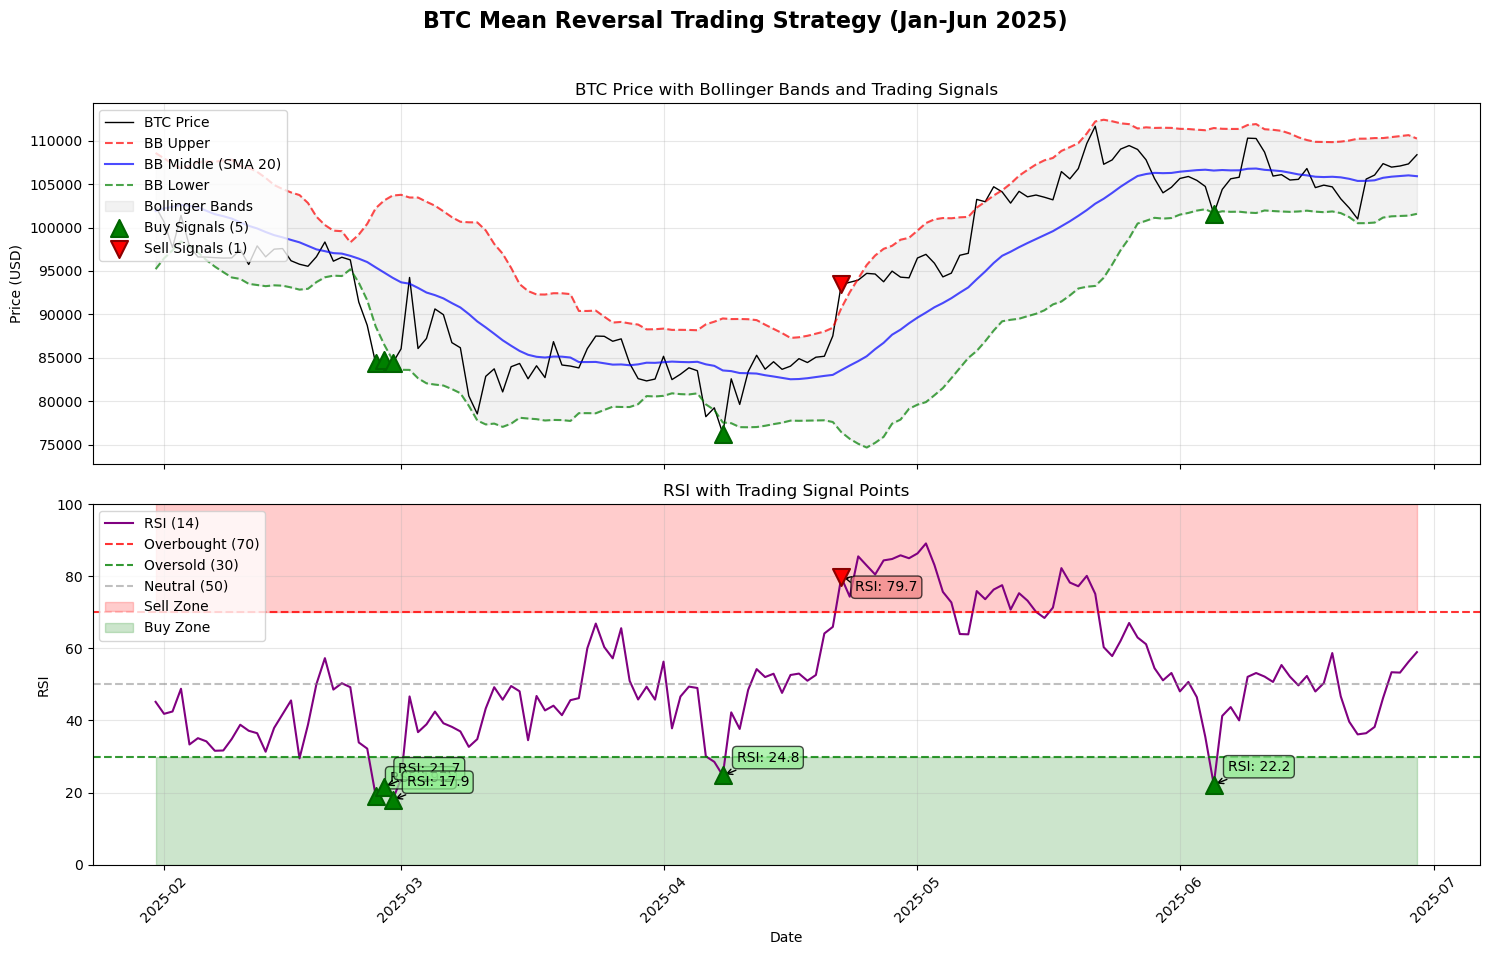


Visualization Summary:
------------------------------
Total Trading Signals Plotted: 6
Buy Signals (Green Triangles): 5
Sell Signals (Red Triangles): 1

Buy Signal Details:
  Buy #1: 2025-02-26 - $84,347.02 (RSI: 19.2)
  Buy #2: 2025-02-27 - $84,704.23 (RSI: 21.7)
  Buy #3: 2025-02-28 - $84,373.01 (RSI: 17.9)
  Buy #4: 2025-04-08 - $76,271.95 (RSI: 24.8)
  Buy #5: 2025-06-05 - $101,575.95 (RSI: 22.2)

Sell Signal Details:
  Sell #1: 2025-04-22 - $93,441.89 (RSI: 79.7)



In [113]:
print("\nCreating visualization for BTC Mean Reversal Strategy...")
print("Plots: Price + Bollinger Bands + Signals, RSI + Trade Points")
print("-" * 60)

# Prepare data for plotting (using the 'test_data' from backtest)
plot_data = test_data.copy()

# Get trade information from the 'trades' list
buy_trades = [t for t in trades if t['action'] == 'BUY']
sell_trades = [t for t in trades if t['action'] == 'SELL']

# Extract buy signals details
buy_dates = [t['date'] for t in buy_trades]
buy_prices = [t['price'] for t in buy_trades]
buy_rsi = [t['rsi'] for t in buy_trades]

# Extract sell signals details
sell_dates = [t['date'] for t in sell_trades]
sell_prices = [t['price'] for t in sell_trades]
sell_rsi = [t['rsi'] for t in sell_trades]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Share x-axis
fig.suptitle('BTC Mean Reversal Trading Strategy (Jan-Jun 2025)', fontsize=16, fontweight='bold')

# --- Plot 1: Price + Bollinger Bands + Trading Signals ---
ax1.plot(plot_data.index, plot_data['close'], label='BTC Price', color='black', linewidth=1)
ax1.plot(plot_data.index, plot_data['bb_upper'], label='BB Upper', color='red', linestyle='--', alpha=0.7)
ax1.plot(plot_data.index, plot_data['bb_middle'], label='BB Middle (SMA 20)', color='blue', alpha=0.7)
ax1.plot(plot_data.index, plot_data['bb_lower'], label='BB Lower', color='green', linestyle='--', alpha=0.7)

# Fill area between bands
ax1.fill_between(plot_data.index, plot_data['bb_upper'], plot_data['bb_lower'],
                   alpha=0.1, color='gray', label='Bollinger Bands')

# Mark buy signals
if buy_dates:
    ax1.scatter(buy_dates, buy_prices, color='green', marker='^', s=150,
                label=f'Buy Signals ({len(buy_dates)})', zorder=5, edgecolors='darkgreen', linewidth=1.5)

# Mark sell signals
if sell_dates:
    ax1.scatter(sell_dates, sell_prices, color='red', marker='v', s=150,
                label=f'Sell Signals ({len(sell_dates)})', zorder=5, edgecolors='darkred', linewidth=1.5)

# Add price annotations for key points (optional, can make plot busy)
# if buy_dates:
#     for date, price in zip(buy_dates, buy_prices):
#         ax1.annotate(f'${price:,.0f}', xy=(date, price), xytext=(10, 10),
#                      textcoords='offset points', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
#                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
# if sell_dates:
#     for date, price in zip(sell_dates, sell_prices):
#         ax1.annotate(f'${price:,.0f}', xy=(date, price), xytext=(10, -10),
#                      textcoords='offset points', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
#                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))


ax1.set_title('BTC Price with Bollinger Bands and Trading Signals')
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)


# --- Plot 2: RSI + Trading Signals ---
ax2.plot(plot_data.index, plot_data['rsi'], label='RSI (14)', color='purple', linewidth=1.5)

# RSI levels
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.8, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.8, label='Oversold (30)')
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Neutral (50)')

# Fill overbought/oversold zones
ax2.fill_between(plot_data.index, 70, 100, alpha=0.2, color='red', label='Sell Zone')
ax2.fill_between(plot_data.index, 0, 30, alpha=0.2, color='green', label='Buy Zone')

# Mark RSI at trading points
if buy_dates:
    ax2.scatter(buy_dates, buy_rsi, color='green', marker='^', s=150,
                zorder=5, edgecolors='darkgreen', linewidth=1.5)

# Add RSI value annotations for buy signals
    for date, rsi_val in zip(buy_dates, buy_rsi):
        ax2.annotate(f'RSI: {rsi_val:.1f}', xy=(date, rsi_val), xytext=(10, 10),
                     textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

if sell_dates:
    ax2.scatter(sell_dates, sell_rsi, color='red', marker='v', s=150,
                zorder=5, edgecolors='darkred', linewidth=1.5)

# Add RSI value annotations for sell signals
    for date, rsi_val in zip(sell_dates, sell_rsi):
        ax2.annotate(f'RSI: {rsi_val:.1f}', xy=(date, rsi_val), xytext=(10, -10),
                     textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.set_title('RSI with Trading Signal Points')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')
ax2.set_ylim(0, 100) # RSI range is 0-100
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format x-axis for better readability
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

# --- Print visualization summary ---
print("\nVisualization Summary:")
print("-" * 30)
print(f"Total Trading Signals Plotted: {len(buy_dates) + len(sell_dates)}")
print(f"Buy Signals (Green Triangles): {len(buy_dates)}")
print(f"Sell Signals (Red Triangles): {len(sell_dates)}")
print()

if buy_dates:
    print("Buy Signal Details:")
    for i, (date, price, rsi_val) in enumerate(zip(buy_dates, buy_prices, buy_rsi), 1):
        print(f"  Buy #{i}: {date.strftime('%Y-%m-%d')} - ${price:,.2f} (RSI: {rsi_val:.1f})")
    print()

if sell_dates:
    print("Sell Signal Details:")
    for i, (date, price, rsi_val) in enumerate(zip(sell_dates, sell_prices, sell_rsi), 1):
        print(f"  Sell #{i}: {date.strftime('%Y-%m-%d')} - ${price:,.2f} (RSI: {rsi_val:.1f})")
    print()

In [114]:
print("MODUL 3.3: Multi-Asset Mean Reversal Strategy")
print("Testing on: BTC, ETH, BNB, SOL, ADA")
print("Period: 1 Jan 2025 - 30 Jun 2025")
print("Initial Capital: $1,000 per asset")
print("=" * 60)

# Step 1: Data Acquisition for Multiple Assets
def get_multi_asset_data(assets=['BTC', 'ETH', 'BNB', 'SOL', 'ADA']):
    asset_data = {}
    for symbol in assets:
        try:
            print(f"Downloading {symbol} data...")
            # Menambahkan progress=False
            data = yf.download(f"{symbol}-USD", start="2025-01-01", end="2025-06-30", progress=False) 

            if hasattr(data.columns, 'levels'):
                data.columns = data.columns.droplevel(1)

            # Clean column names
            new_columns = []
            for col in data.columns:
                if isinstance(col, str):
                    new_col = col.lower().replace(' ', '_')
                else:
                    new_col = str(col).lower().replace(' ', '_')
                new_columns.append(new_col)
            data.columns = new_columns
            
            asset_data[symbol] = data
            
            print(f"  ✅ {symbol}: {len(data)} days loaded")
            print(f"     Start: ${data['close'].iloc[0]:,.2f}")
            print(f"     End: ${data['close'].iloc[-1]:,.2f}")
            price_change = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
            print(f"     Price Change: {price_change:+.2f}%")

        except Exception as e:
            print(f"❌ Error loading {symbol}: {e}")
            
    return asset_data

# Load multi-asset data
print("\nSTEP 1: Loading multi-asset data...")
asset_data = get_multi_asset_data()
print(f"✅ Successfully loaded {len(asset_data)} assets\n")

MODUL 3.3: Multi-Asset Mean Reversal Strategy
Testing on: BTC, ETH, BNB, SOL, ADA
Period: 1 Jan 2025 - 30 Jun 2025
Initial Capital: $1,000 per asset

STEP 1: Loading multi-asset data...
  ✅ BTC: 180 days loaded
     Start: $94,419.76
     End: $108,385.57
     Price Change: +14.79%
  ✅ ETH: 180 days loaded
     Start: $3,353.50
     End: $2,500.96
     Price Change: -25.42%
  ✅ BNB: 180 days loaded
     Start: $706.51
     End: $655.04
     Price Change: -7.29%
  ✅ SOL: 180 days loaded
     Start: $193.87
     End: $153.35
     Price Change: -20.90%
  ✅ ADA: 180 days loaded
     Start: $0.92
     End: $0.58
     Price Change: -37.00%
✅ Successfully loaded 5 assets



In [115]:
# Step 2: Add Indicators to All Assets
def add_indicators_to_asset(df):
    """Adds Bollinger Bands and RSI indicators to the dataframe."""
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    rolling_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (rolling_std * 2)
    df['bb_lower'] = df['bb_middle'] - (rolling_std * 2)

    # RSI
    price_change = df['close'].diff()
    gains = price_change.where(price_change > 0, 0)
    losses = -price_change.where(price_change < 0, 0)
    # Use Simple Moving Average for RSI calculation as shown
    avg_gains = gains.rolling(window=14).mean()
    avg_losses = losses.rolling(window=14).mean()
    rs = avg_gains / avg_losses.replace(0, np.nan) # Avoid division by zero
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi'] = df['rsi'].fillna(50) # Fill initial NaNs with neutral 50

    return df

print("STEP 2: Adding indicators to all assets...")
for symbol in asset_data.keys():
    asset_data[symbol] = add_indicators_to_asset(asset_data[symbol])
    # Calculate RSI range after removing NaNs that might exist before fillna
    rsi_range = asset_data[symbol]['rsi'].dropna()
    print(f"  ✅ {symbol} indicators added - RSI range: {rsi_range.min():.1f} - {rsi_range.max():.1f}")

print()

STEP 2: Adding indicators to all assets...
  ✅ BTC indicators added - RSI range: 17.9 - 89.1
  ✅ ETH indicators added - RSI range: 14.3 - 91.6
  ✅ BNB indicators added - RSI range: 18.0 - 79.5
  ✅ SOL indicators added - RSI range: 12.2 - 82.8
  ✅ ADA indicators added - RSI range: 8.4 - 77.7



In [116]:
# Step 3: Backtest Function for Mean Reversal Strategy
def run_mean_reversal_backtest(symbol, data, initial_capital=1000):
    """
    Run backtest for mean reversal strategy on a single asset.
    """
    print(f"\nRunning backtest for {symbol}...")
    
    # Initialize trading state variables for this specific backtest
    current_cash = initial_capital
    crypto_holdings = 0
    avg_buy_price = 0
    total_invested = 0
    trades = []
    daily_values = [] # Track portfolio value over time

    # Skip initial rows where indicators are still calculating (NaN)
    test_data = data.dropna(subset=['bb_lower', 'bb_upper', 'rsi']).copy()
    if len(test_data) < 1:
        print(f"   Not enough data after dropping NaNs for {symbol}. Skipping.")
        return None # Return None if no valid data

    for date, row in test_data.iterrows():
        price = row['close']
        rsi = row['rsi']
        bb_upper = row['bb_upper']
        bb_lower = row['bb_lower']

        # Simple trading signals
        buy_signal = (rsi < 30 and price < bb_lower)
        sell_signal = (rsi > 70 and price > bb_upper and crypto_holdings > 0)

        trade_executed_today = False # Flag to prevent buy and sell on the same day

        if buy_signal and not trade_executed_today:
            # Execute Buy (using 50% of cash)
            investment = current_cash * 0.5
            if investment > 50: # Minimum trade size
                fee = investment * 0.001
                net_investment = investment - fee
                crypto_bought = net_investment / price
                
                if crypto_holdings > 0:
                    total_value = (crypto_holdings * avg_buy_price) + net_investment
                    total_crypto = crypto_holdings + crypto_bought
                    avg_buy_price = total_value / total_crypto
                else:
                    avg_buy_price = price
                
                crypto_holdings += crypto_bought
                total_invested += net_investment
                current_cash -= investment
                trade_executed_today = True

                trades.append({
                    'date': date, 'action': 'BUY', 'price': price,
                    'amount': investment, 'rsi': rsi
                })

        elif sell_signal and not trade_executed_today:
            # Execute Sell (all holdings)
            sell_value = crypto_holdings * price
            fee = sell_value * 0.001
            net_proceeds = sell_value - fee
            profit = net_proceeds - total_invested if total_invested > 0 else net_proceeds # Handle case where total_invested might be 0
            trade_executed_today = True

            trades.append({
                'date': date, 'action': 'SELL', 'price': price,
                'proceeds': net_proceeds, 'profit': profit, 'rsi': rsi
            })
            
            # Reset position state after selling
            current_cash += net_proceeds
            crypto_holdings = 0
            avg_buy_price = 0
            total_invested = 0

        # Record daily portfolio value regardless of trade
        portfolio_value = current_cash + (crypto_holdings * price)
        daily_values.append({
            'date': date,
            'price': price,
            'portfolio_value': portfolio_value,
            'cash': current_cash,
            'crypto_value': crypto_holdings * price,
            'rsi': rsi,
            'bb_upper': bb_upper,
            'bb_lower': bb_lower
        })

    # Final calculations after the loop
    final_price = test_data['close'].iloc[-1]
    final_portfolio_value = current_cash + (crypto_holdings * final_price)
    total_return = final_portfolio_value - initial_capital
    return_pct = (total_return / initial_capital) * 100

    # HODL comparison (corrected) - Use actual first day price of test_data
    start_price = test_data['close'].iloc[0] 
    hodl_btc = initial_capital / start_price 
    hodl_final_value = hodl_btc * final_price
    hodl_return = hodl_final_value - initial_capital
    hodl_return_pct = (hodl_return / initial_capital) * 100

    results = {
        'symbol': symbol,
        'trades': pd.DataFrame(trades),
        'daily_values': pd.DataFrame(daily_values),
        'final_portfolio_value': final_portfolio_value,
        'total_return': total_return,
        'return_pct': return_pct,
        'current_cash': current_cash, # Final cash
        'crypto_holdings': crypto_holdings, # Final holdings
        'hodl_return_pct': hodl_return_pct,
        'outperformance': return_pct - hodl_return_pct
    }
    
    print(f"   ✅ Backtest Complete for {symbol}")
    print(f"      {symbol} Strategy Return: {return_pct:+.2f}%")
    print(f"      {symbol} HODL Return: {hodl_return_pct:+.2f}%")
    print(f"      {symbol} Outperformance: {results['outperformance']:+.2f}%")

    return results

print("-" * 60) # Separator after function definition

------------------------------------------------------------


In [117]:
# Step 4: Run Strategy for All Assets
print("\nSTEP 4: Running strategies for all assets...")
all_results = {}

for symbol in asset_data.keys():
    # Use the previously defined backtest function
    result = run_mean_reversal_backtest(symbol, asset_data[symbol]) 
    if result: # Store result only if backtest was successful
        all_results[symbol] = result

print("\n🏁 All backtests completed.")


STEP 4: Running strategies for all assets...

Running backtest for BTC...
   ✅ Backtest Complete for BTC
      BTC Strategy Return: +14.16%
      BTC HODL Return: +6.24%
      BTC Outperformance: +7.91%

Running backtest for ETH...
   ✅ Backtest Complete for ETH
      ETH Strategy Return: -14.51%
      ETH HODL Return: -23.71%
      ETH Outperformance: +9.20%

Running backtest for BNB...
   ✅ Backtest Complete for BNB
      BNB Strategy Return: +4.67%
      BNB HODL Return: -3.93%
      BNB Outperformance: +8.60%

Running backtest for SOL...
   ✅ Backtest Complete for SOL
      SOL Strategy Return: +26.78%
      SOL HODL Return: -36.70%
      SOL Outperformance: +63.48%

Running backtest for ADA...
   ✅ Backtest Complete for ADA
      ADA Strategy Return: +64.79%
      ADA HODL Return: -42.69%
      ADA Outperformance: +107.47%

🏁 All backtests completed.


In [118]:
# Step 5: Portfolio Summary
print("\nSTEP 5: Multi-Asset Portfolio Summary")
print("=" * 50)

# Pastikan all_results tidak kosong sebelum kalkulasi
if all_results:
    total_initial_capital = len(all_results) * 1000 # $1000 per asset
    total_final_value = sum(result['final_portfolio_value'] for result in all_results.values())
    total_return = total_final_value - total_initial_capital
    overall_return_pct = (total_return / total_initial_capital) * 100

    print(f"💰 Total Initial Capital: ${total_initial_capital:,.2f}")
    print(f"📈 Total Final Value: ${total_final_value:,.2f}")
    # Perbaikan format (tanpa spasi setelah koma)
    print(f"💸 Total Return: ${total_return:+,.2f}") 
    print(f"🚀 Overall Return: {overall_return_pct:+.2f}%")
    print()

    print("Individual Asset Performance:")
    print("-" * 50)
    for symbol, result in all_results.items():
        print(f"🪙 {symbol}:")
        print(f"   Final Value: ${result['final_portfolio_value']:,.2f}")
        print(f"   Return: {result['return_pct']:+.2f}%")
        print(f"   vs HODL: {result['outperformance']:+.2f}%")
        # Pastikan 'trades' adalah DataFrame sebelum menghitung len
        if isinstance(result.get('trades'), pd.DataFrame): 
             print(f"   Trades: {len(result['trades'])}")
        else:
             print("   Trades: N/A") # Jika trades tidak ada atau bukan DataFrame
        print()
else:
    print("No backtest results available to summarize.")


STEP 5: Multi-Asset Portfolio Summary
💰 Total Initial Capital: $5,000.00
📈 Total Final Value: $5,958.93
💸 Total Return: $+958.93
🚀 Overall Return: +19.18%

Individual Asset Performance:
--------------------------------------------------
🪙 BTC:
   Final Value: $1,141.57
   Return: +14.16%
   vs HODL: +7.91%
   Trades: 6

🪙 ETH:
   Final Value: $854.94
   Return: -14.51%
   vs HODL: +9.20%
   Trades: 5

🪙 BNB:
   Final Value: $1,046.71
   Return: +4.67%
   vs HODL: +8.60%
   Trades: 6

🪙 SOL:
   Final Value: $1,267.85
   Return: +26.78%
   vs HODL: +63.48%
   Trades: 6

🪙 ADA:
   Final Value: $1,647.86
   Return: +64.79%
   vs HODL: +107.47%
   Trades: 13




STEP 6: Visualizing Backtest Results...


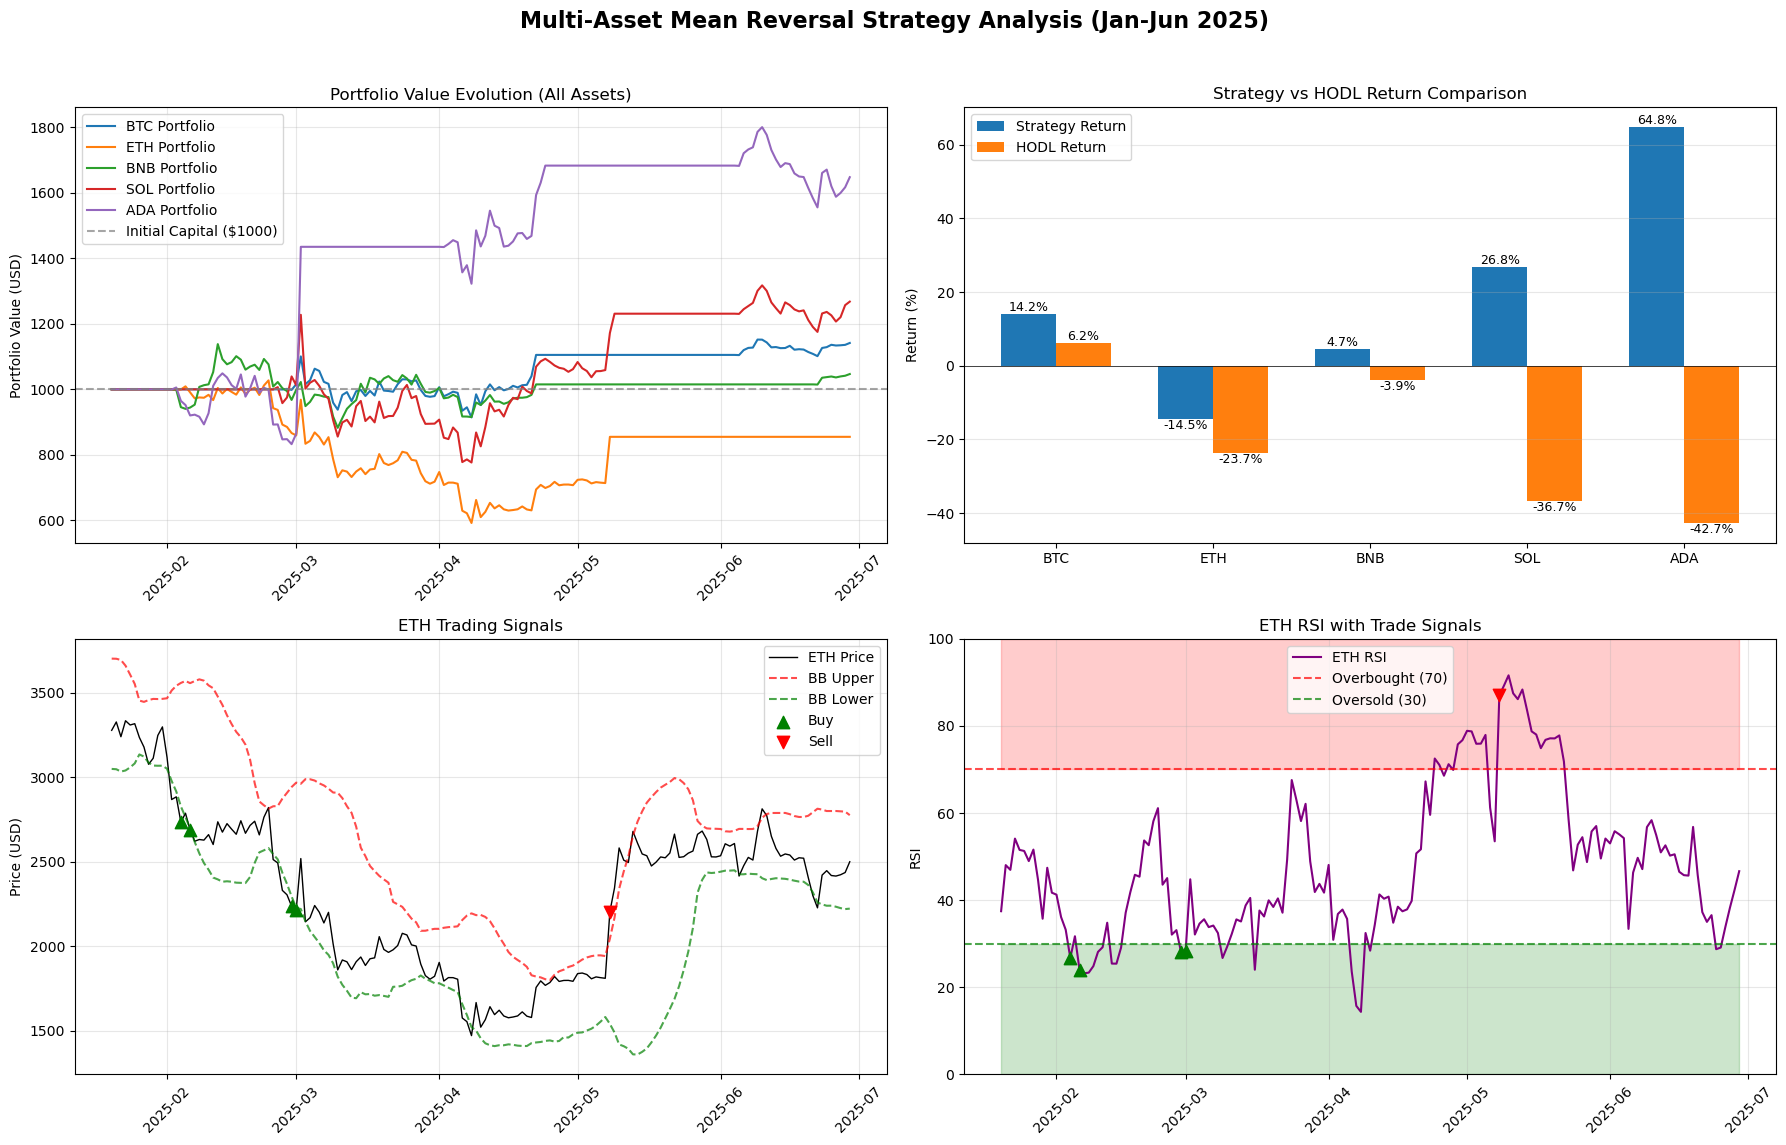

In [119]:
# ==============================================================================
# STEP 6: VISUALIZING BACKTEST RESULTS (Corrected Indentation)
# ==============================================================================

print("\nSTEP 6: Visualizing Backtest Results...")

# Check if there are results to plot
if not all_results:
    print("   ⚠️ No backtest results available to visualize.")
else:
    # --- INDENTASI DIMULAI DI SINI UNTUK SEMUA PLOT ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Multi-Asset Mean Reversal Strategy Analysis (Jan-Jun 2025)', fontsize=16, fontweight='bold')
    
    axes = axes.flatten() # Flatten axes array

    # --- Plot 1: Portfolio Value Evolution (All Assets) ---
    ax1 = axes[0]
    for symbol, result in all_results.items():
        if 'daily_values' in result and not result['daily_values'].empty: 
            daily_df = result['daily_values']
            ax1.plot(daily_df['date'], daily_df['portfolio_value'], label=f'{symbol} Portfolio', linewidth=1.5)
    
    ax1.axhline(1000, color='gray', linestyle='--', label='Initial Capital ($1000)', alpha=0.7)
    ax1.set_title('Portfolio Value Evolution (All Assets)') 
    ax1.set_ylabel('Portfolio Value (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # --- Plot 2: Strategy vs HODL Comparison (Bar Chart) ---
    ax2 = axes[1] # Pastikan inden ini benar
    symbols = list(all_results.keys())
    returns_pct = [all_results[s].get('return_pct', 0) for s in symbols]
    hodl_returns_pct = [all_results[s].get('hodl_return_pct', 0) for s in symbols]
    x = np.arange(len(symbols))
    width = 0.35
    bars1 = ax2.bar(x - width/2, returns_pct, width, label='Strategy Return')
    bars2 = ax2.bar(x + width/2, hodl_returns_pct, width, label='HODL Return')
    ax2.set_ylabel('Return (%)')
    ax2.set_title('Strategy vs HODL Return Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(symbols)
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.5)
    for bar in bars1: height = bar.get_height(); ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom' if height >=0 else 'top', fontsize=9)
    for bar in bars2: height = bar.get_height(); ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom' if height >=0 else 'top', fontsize=9)

    # --- Plot 3: ETH Trading Signals Detail ---
    ax3 = axes[2] # Pastikan inden ini benar
    if 'ETH' in all_results:
        eth_daily = pd.DataFrame(all_results['ETH']['daily_values'])
        eth_trades = all_results['ETH']['trades'] 
        if not eth_daily.empty:
            ax3.plot(eth_daily['date'], eth_daily['price'], label='ETH Price', color='black', linewidth=1)
            ax3.plot(eth_daily['date'], eth_daily['bb_upper'], label='BB Upper', color='red', linestyle='--', alpha=0.7)
            ax3.plot(eth_daily['date'], eth_daily['bb_lower'], label='BB Lower', color='green', linestyle='--', alpha=0.7)
            if not eth_trades.empty:
                buy_trades = eth_trades[eth_trades['action'] == 'BUY']
                sell_trades = eth_trades[eth_trades['action'] == 'SELL']
                if not buy_trades.empty: ax3.scatter(buy_trades['date'], buy_trades['price'], color='green', marker='^', s=80, zorder=5, label='Buy')
                if not sell_trades.empty: ax3.scatter(sell_trades['date'], sell_trades['price'], color='red', marker='v', s=80, zorder=5, label='Sell')
            ax3.set_title('ETH Trading Signals')
            ax3.set_ylabel('Price (USD)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
        else:
            ax3.set_title('ETH Trading Signals'); ax3.text(0.5, 0.5, 'No ETH daily data', ha='center', va='center')
    else:
        ax3.set_title('ETH Result Not Available')

    # --- Plot 4: RSI Levels for ETH ---
    ax4 = axes[3] # Pastikan inden ini benar
    if 'ETH' in all_results:
        eth_daily = pd.DataFrame(all_results['ETH']['daily_values']) 
        eth_trades = all_results['ETH']['trades']
        if not eth_daily.empty:
            ax4.plot(eth_daily['date'], eth_daily['rsi'], label='ETH RSI', color='purple', linewidth=1.5)
            ax4.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
            ax4.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
            ax4.fill_between(eth_daily['date'], 70, 100, alpha=0.2, color='red')
            ax4.fill_between(eth_daily['date'], 0, 30, alpha=0.2, color='green')
            if not eth_trades.empty:
                 buy_trades = eth_trades[eth_trades['action'] == 'BUY']
                 sell_trades = eth_trades[eth_trades['action'] == 'SELL']
                 if not buy_trades.empty: ax4.scatter(buy_trades['date'], buy_trades['rsi'], color='green', marker='^', s=80, zorder=5)
                 if not sell_trades.empty: ax4.scatter(sell_trades['date'], sell_trades['rsi'], color='red', marker='v', s=80, zorder=5)
            ax4.set_title('ETH RSI with Trade Signals')
            ax4.set_ylabel('RSI')
            ax4.set_ylim(0, 100)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            ax4.tick_params(axis='x', rotation=45)
        else:
            ax4.set_title('ETH RSI with Trade Signals'); ax4.text(0.5, 0.5, 'No ETH daily data', ha='center', va='center')
    else:
        ax4.set_title('ETH Result Not Available')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
    # --- AKHIR DARI BLOK INDEN ---

In [120]:
# Step 7: Detailed Analysis
print("\nSTEP 7: Detailed Trade Analysis")
print("=" * 50)

# Initialize overall metrics if not already done in summary step
if 'overall_return_pct' not in locals(): # Check if it exists from previous cell
    if all_results:
        total_initial_capital = len(all_results) * 1000
        total_final_value = sum(result['final_portfolio_value'] for result in all_results.values())
        total_return = total_final_value - total_initial_capital
        overall_return_pct = (total_return / total_initial_capital) * 100
    else:
        overall_return_pct = 0 # Default if no results

for symbol, result in all_results.items():
    trades = result['trades'] # Assumes trades is already a DataFrame
    
    # Check if trades DataFrame is empty before proceeding
    if trades.empty:
        print(f"\n🪙 {symbol} TRADE DETAILS:")
        print("   No trades executed.")
        continue # Skip to the next symbol

    buy_trades = trades[trades['action'] == 'BUY']
    sell_trades = trades[trades['action'] == 'SELL']
    
    print(f"\n🪙 {symbol} TRADE DETAILS:")
    print(f"   Total Trades: {len(trades)}")
    print(f"   Buy Orders: {len(buy_trades)}")
    print(f"   Sell Orders: {len(sell_trades)}")
    
    # Calculate statistics only if there are sell trades
    if not sell_trades.empty:
        profits = sell_trades['profit'].dropna() # Get profits from sell trades, drop NaNs
        winning_trades = profits[profits > 0]
        
        # Calculate win rate and avg profit safely
        win_rate = len(winning_trades) / len(profits) * 100 if len(profits) > 0 else 0
        avg_profit = profits.mean() if not profits.empty else 0
        max_profit = profits.max() if not profits.empty else 0
        min_profit = profits.min() if not profits.empty else 0 # Will be the biggest loss

        print(f"   Win Rate: {win_rate:.1f}%")
        print(f"   Average Profit per Trade: ${avg_profit:+.2f}")
        print(f"   Best Trade: ${max_profit:+.2f}")
        print(f"   Worst Trade: ${min_profit:+.2f}")
    else:
        print("   No sell trades to analyze profit metrics.")

# --- Final Summary ---
print("\n" + "=" * 60)
print("✅ MODUL 3.3 COMPLETED SUCCESSFULLY!")
print("Multi-asset mean reversion strategy analysis complete.")
print("\nKey findings:")
if all_results:
    print(f"📈 Overall portfolio return: {overall_return_pct:+.2f}%")
    # Find best/worst based on return_pct
    best_performer = max(all_results.keys(), key=lambda k: all_results[k]['return_pct'])
    worst_performer = min(all_results.keys(), key=lambda k: all_results[k]['return_pct'])
    print(f"🟢 Best performing asset: {best_performer} ({all_results[best_performer]['return_pct']:+.2f}%)")
    print(f"🔴 Worst performing asset: {worst_performer} ({all_results[worst_performer]['return_pct']:+.2f}%)")
else:
    print("   No results to determine best/worst performers.")
print("=" * 60)


STEP 7: Detailed Trade Analysis

🪙 BTC TRADE DETAILS:
   Total Trades: 6
   Buy Orders: 5
   Sell Orders: 1
   Win Rate: 100.0%
   Average Profit per Trade: $+106.06
   Best Trade: $+106.06
   Worst Trade: $+106.06

🪙 ETH TRADE DETAILS:
   Total Trades: 5
   Buy Orders: 4
   Sell Orders: 1
   Win Rate: 0.0%
   Average Profit per Trade: $-144.12
   Best Trade: $-144.12
   Worst Trade: $-144.12

🪙 BNB TRADE DETAILS:
   Total Trades: 6
   Buy Orders: 5
   Sell Orders: 1
   Win Rate: 100.0%
   Average Profit per Trade: $+16.02
   Best Trade: $+16.02
   Worst Trade: $+16.02

🪙 SOL TRADE DETAILS:
   Total Trades: 6
   Buy Orders: 5
   Sell Orders: 1
   Win Rate: 100.0%
   Average Profit per Trade: $+231.92
   Best Trade: $+231.92
   Worst Trade: $+231.92

🪙 ADA TRADE DETAILS:
   Total Trades: 13
   Buy Orders: 11
   Sell Orders: 2
   Win Rate: 100.0%
   Average Profit per Trade: $+342.74
   Best Trade: $+436.13
   Worst Trade: $+249.34

✅ MODUL 3.3 COMPLETED SUCCESSFULLY!
Multi-asset mean r